# Fine Tune a Generative AI Model for Dialogue Summarization

- Fine-tune an existing LLM from Hugging Face [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) for dialogue summarization.
- Improve inferences, with full fine-tuning approach.
- Evaluate the results with ROUGE metrics.
- PEFT (Parameter Efficient Fine-Tuning),

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
# SOme times when new files are added to the drive colab dose not regonise them
# Unmounting and mounting helps to solve the problem

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 973.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.16.0 

In [4]:
! pip install transformers


In [5]:
#import required libraries
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np


### Load Dataset

In [6]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-cd36827d3490488d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
})

**Flan T5 docs**
- https://huggingface.co/docs/transformers/model_doc/flan-t5
- https://huggingface.co/google/flan-t5-base

### Load LLM

In [8]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

(…)le/flan-t5-base/resolve/main/config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

(…)base/resolve/main/generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

(…)-base/resolve/main/tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

(…)flan-t5-base/resolve/main/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

(…)ase/resolve/main/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [9]:
# Finding number of parameter (trainable and non trainable)
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%



### Zero Shot


In [ ]:

index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------


## Full Fine-Tuning
- **NOTE:** Model struggles to summarize the dialogue in zero shot. It has shown some evidance of important information in the summary. Fine tunning will help further


### Preprocess the  Dataset
The input needs to be in a perticular order

Training prompt (dialogue):

Summarize the following conversation.

- Tom: Hello mate!! How are you
- Mischa: I am doing great. Such a nice weather, how about you.
    
Summary:


Then preprocess the prompt-response dataset into tokens and pull out their input_ids (1 per token).

In [10]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [11]:
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Check the shapes of all three parts of the dataset:

In [ ]:
print("Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (125, 2)
Validation: (5, 2)
Test: (15, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 125
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 5
    })
})



### Fine tune with preprocessed dataset


In [ ]:
output_dir = f'./dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)
#https://huggingface.co/docs/transformers/main_classes/trainer

In [ ]:
trainer.train()

In [ ]:
!aws s3 cp --recursive s3:********************************* ./flan-dialogue-summary-checkpoint/
#morphed the s3 bucket as can't take the path out of organisation
#I have downloaded the file for my use and place it in the right folder

/bin/bash: line 1: aws: command not found


In [15]:
!ls -alh /content/drive/MyDrive/LLM/flan-dialogue-summary-checkpoint/pytorch_model.bin

-rw------- 1 root root 945M Oct 24 22:11 /content/drive/MyDrive/LLM/flan-dialogue-summary-checkpoint/pytorch_model.bin


Create an instance of the `AutoModelForSeq2SeqLM` class for the instruct model:

In [ ]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/LLM/flan-dialogue-summary-checkpoint", torch_dtype=torch.bfloat16)


### Evaluate model qualitatively in other words human evaluation



In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1#: I'm thinking of upgrading my computer.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
#Person1# suggests #Person2# adding a painting program to #Person2#'s software and upgrading the hardware. #Person2# also wants to add a CD-ROM drive.



### Evaluate model quantitatively with ROUGE Metric

ROUGE metric https://en.wikipedia.org/wiki/ROUGE_(metric)

In [ ]:
rouge = evaluate.load('rouge')

Generate the outputs for the sample of the test dataset (only 10 dialogues and summaries to save time), and save the results.

In [ ]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    instruct_model_summaries.append(instruct_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...
1,In order to prevent employees from wasting tim...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...
2,Ms. Dawson takes a dictation for #Person1# abo...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...
3,#Person2# arrives late because of traffic jam....,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...
4,#Person2# decides to follow #Person1#'s sugges...,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...
5,#Person2# complains to #Person1# about the tra...,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...
9,#Person1# and Brian are at the birthday party ...,"#Person1#: Happy birthday, Brian. #Person2#: I...",Brian's birthday is coming. #Person1# invites ...


Evaluate the models computing ROUGE metrics. Notice the improvement in the results!

In [ ]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.241950545026632, 'rouge2': 0.1179539641943734, 'rougeL': 0.22166387959866218, 'rougeLsum': 0.22283940294809862}
INSTRUCT MODEL:
{'rouge1': 0.41026607717457186, 'rouge2': 0.17840645241958838, 'rougeL': 0.2977022096267017, 'rougeLsum': 0.2987374187518165}


In [ ]:
results = pd.read_csv("/content/drive/MyDrive/LLM/data/dialogue-summary-training-results.csv") #pre poplulated file


human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2334158581572823, 'rouge2': 0.07603964187010573, 'rougeL': 0.20145520923859048, 'rougeLsum': 0.20145899339006135}
INSTRUCT MODEL:
{'rouge1': 0.42161291557556113, 'rouge2': 0.18035380596301792, 'rougeL': 0.3384439349963909, 'rougeLsum': 0.33835653595561666}


The results show substantial improvement in all ROUGE metrics:

In [ ]:
print("Absolute percentage improvement of INSTRUCT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(instruct_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of INSTRUCT MODEL over ORIGINAL MODEL
rouge1: 16.83%
rouge2: 6.05%
rougeL: 7.60%
rougeLsum: 7.59%



## PEFT (Perform Parameter Efficient Fine-Tuning) / LoRA for fine tunning

**LoRA**
Low rank adaptation matrix is PEFT fine tunning method.
- In this method the weight of the self attention and feed forward layer id learned during the pretraining.
-  Lora freeze most of the original llm weights and injects 2 rank decomposition matrices.
- Train the weight of the maller matrices.
- The parameter is which is rank is a small dimesion typcally even 4,6,8....64.

#  Inference:
- Concider a weight matrics of size 512 X 64 (original transformer wight as in the parper)
- So the toal number of weight is 32768 (trainable parameter)

In case of LoRA with rank r = 8.
- matrix A has a dimesion of 8 X 64 (512 parameter)
- matrix B has a dimesion of 8 X 512 (4096 parameter)

total parameter = 4608 about 80% reduction in parameter.
- **Step 1**
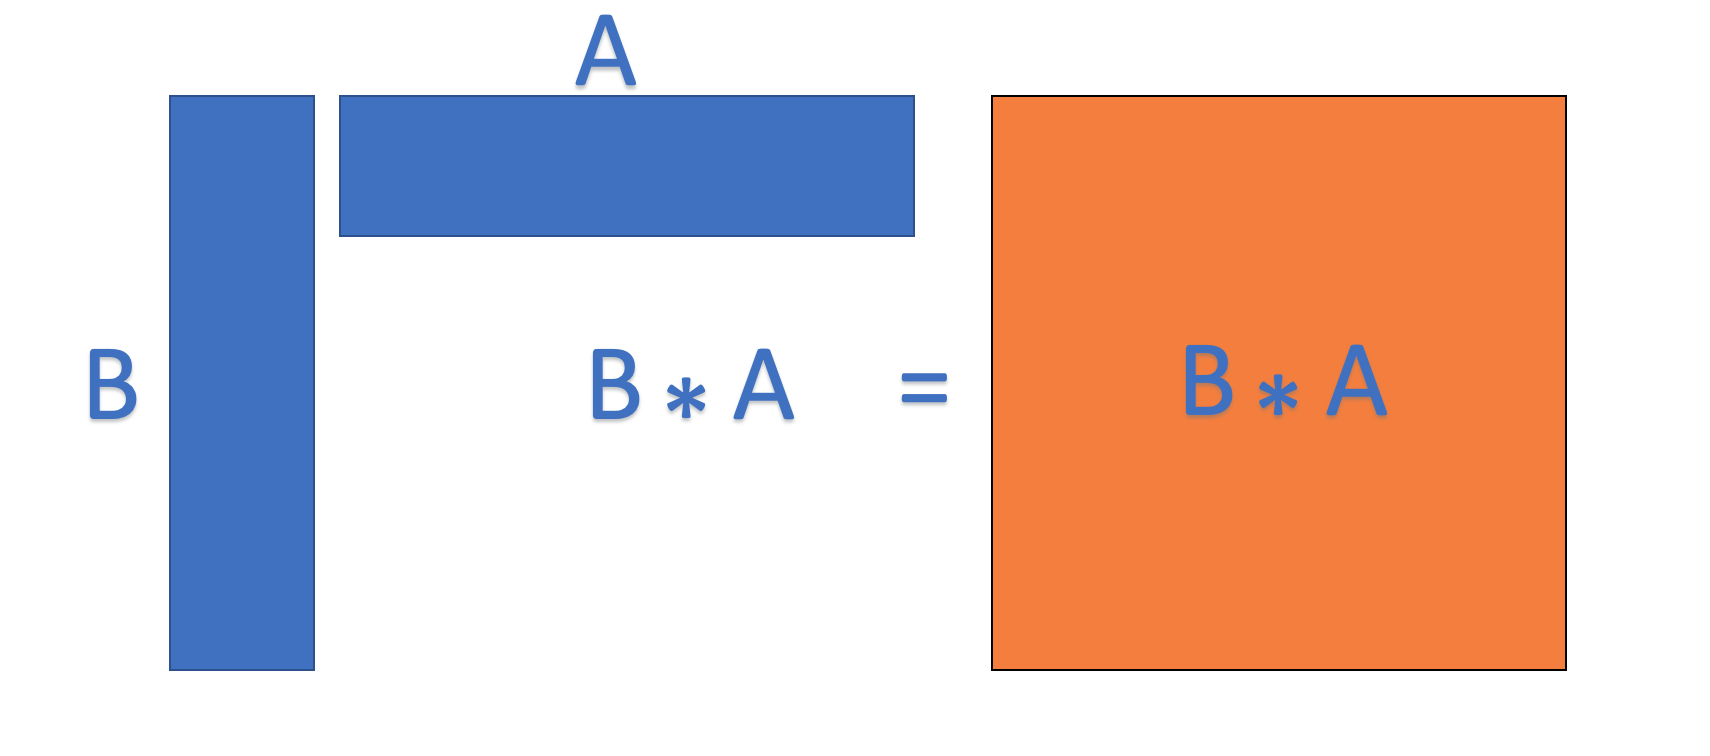
- **Step 2**
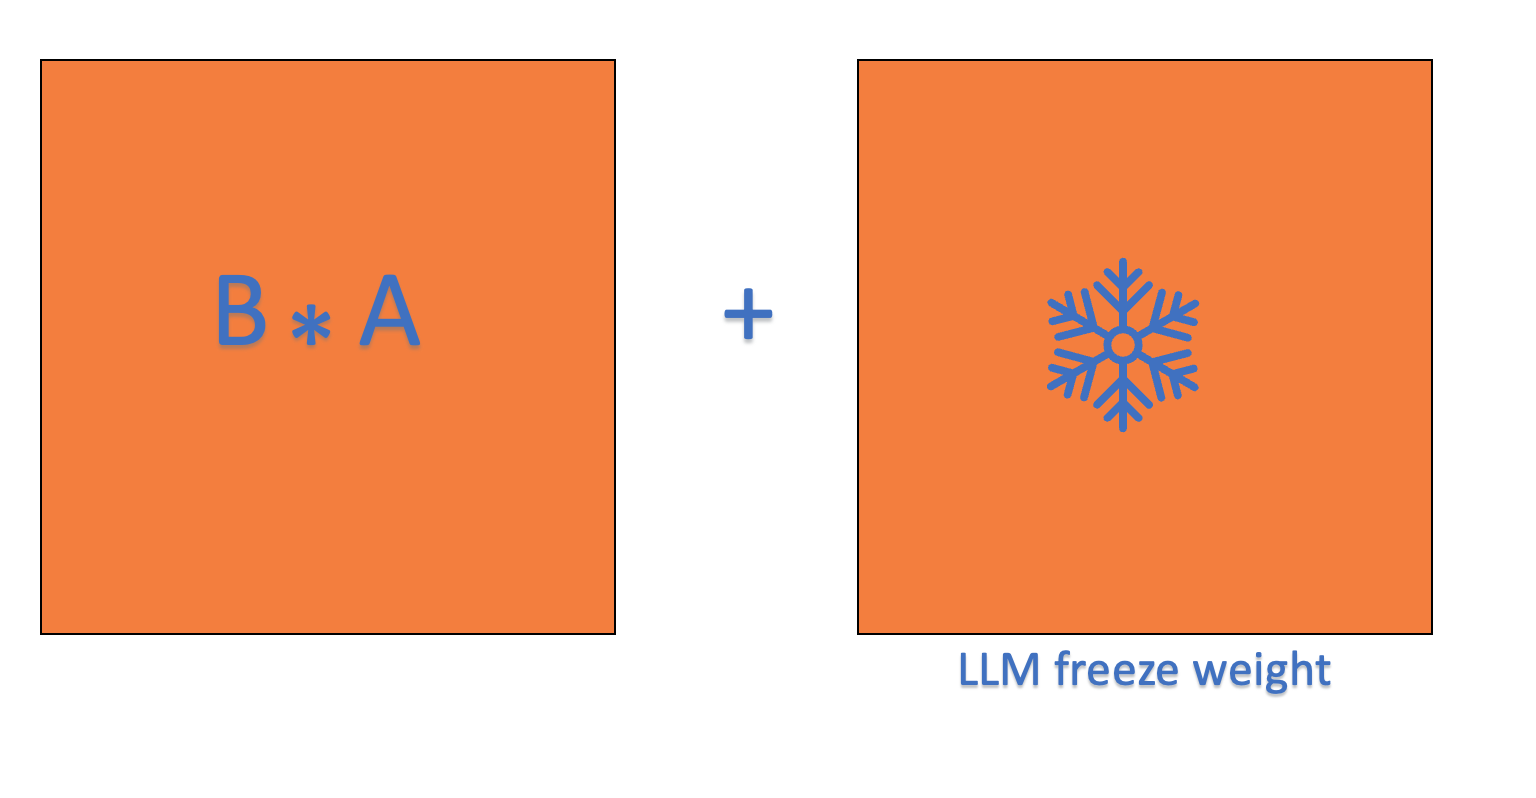

In [ ]:
#import peft and set the LoRA parameters
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

In [ ]:
peft_model = get_peft_model(original_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))
#Add LoRA adapter layers

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%



### Train PEFT Adapter

In [ ]:
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=1,
    logging_steps=1,
    max_steps=1
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

In [ ]:
peft_trainer.train()

peft_model_path="/content/drive/MyDrive/LLM/peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

In [ ]:
!aws s3 cp --recursive s3:***************** ./peft-dialogue-summary-checkpoint-from-s3/

#Full data set traing check point from s3
#have morphed the s3 as can have path in public

In [16]:
!ls -al /content/drive/MyDrive/LLM/peft-dialogue-summary-checkpoint-from-s3/adapter_model.bin
#clearly this is smaller than llm

-rw------- 1 root root 14208525 Oct 24 22:29 /content/drive/MyDrive/LLM/peft-dialogue-summary-checkpoint-from-s3/adapter_model.bin


In [18]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       '/content/drive/MyDrive/LLM/peft-dialogue-summary-checkpoint-from-s3/',
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [19]:
print(print_number_of_trainable_model_parameters(peft_model))
#trainable parameters is 0 as is_trainable=False

trainable model parameters: 0
all model parameters: 251116800
percentage of trainable model parameters: 0.00%


<a name='3.3'></a>
### 3.3 - Evaluate the Model Qualitatively (Human Evaluation)

Make inferences for the same example as in sections [1.3](#1.3) and [2.3](#2.3), with the original model, fully fine-tuned and PEFT model.

In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1#: I think you'd be interested in adding a painting program to your software.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
#Person1# suggests #Person2# adding a painting program to #Person2#'s software and upgrading the hardware. #Person2# also wants to add a CD-ROM drive.
---------------------------------------------------------------------------------------------------
PEFT MODEL: #Person1# recommends adding a painting program to #Person2#'s software and upgrading hardware. #Person2# also wants to upgrade the hardware because it's outdated now.



### Evaluate model qualitatively in other words human evaluation

In [ ]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    human_baseline_text_output = human_baseline_summaries[idx]

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,Employees are being notified that they must ch...,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
1,In order to prevent employees from wasting tim...,#Person1#: I want to have this memo out before...,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
2,Ms. Dawson takes a dictation for #Person1# abo...,This memo is for all employees.,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
3,#Person2# arrives late because of traffic jam....,People are getting better at driving than driv...,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
4,#Person2# decides to follow #Person1#'s sugges...,Getting stuck in traffic.,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
5,#Person2# complains to #Person1# about the tra...,People are discussing the benefits of cycling ...,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
9,#Person1# and Brian are at the birthday party ...,"#Person1#: Happy birthday, Brian. #Person2#: H...",Brian's birthday is coming. #Person1# invites ...,Brian remembers his birthday and invites #Pers...


In [ ]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.22380121283569554, 'rouge2': 0.08268842755799277, 'rougeL': 0.1884382284382284, 'rougeLsum': 0.19135055238503512}
INSTRUCT MODEL:
{'rouge1': 0.41026607717457186, 'rouge2': 0.17840645241958838, 'rougeL': 0.2977022096267017, 'rougeLsum': 0.2987374187518165}
PEFT MODEL:
{'rouge1': 0.3725351062275605, 'rouge2': 0.12138811933618107, 'rougeL': 0.27620639623170606, 'rougeLsum': 0.2758134870822362}


In [ ]:
human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values
peft_model_summaries     = results['peft_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2334158581572823, 'rouge2': 0.07603964187010573, 'rougeL': 0.20145520923859048, 'rougeLsum': 0.20145899339006135}
INSTRUCT MODEL:
{'rouge1': 0.42161291557556113, 'rouge2': 0.18035380596301792, 'rougeL': 0.3384439349963909, 'rougeLsum': 0.33835653595561666}
PEFT MODEL:
{'rouge1': 0.40810631575616746, 'rouge2': 0.1633255794568712, 'rougeL': 0.32507074586565354, 'rougeLsum': 0.3248950182867091}


The results show less of an improvement over full fine-tuning, but the benefits of PEFT typically outweigh the slightly-lower performance metrics.

Calculate the improvement of PEFT over the original model:

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 17.47%
rouge2: 8.73%
rougeL: 12.36%
rougeLsum: 12.34%


Now calculate the improvement of PEFT over a full fine-tuned model:

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL
rouge1: -1.35%
rouge2: -1.70%
rougeL: -1.34%
rougeLsum: -1.35%


Here you see a small percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).